# 3. Using the Fast Gradient Sign Attack to Generate Attack Samples

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.1 (20/02/2023)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Pillow (tested on v9.0.0)
- Torch (tested on v1.12.1)
- Torchvision (tested on v0.13.1)

### Imports

In [1]:
# Future
from __future__ import print_function
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Torchvision
from torchvision import datasets, transforms

In [2]:
# NOTE: This is a fix to work around the "User-agent" issue 
# when downloading the MNIST dataset
from six.moves import urllib
opener_req = urllib.request.build_opener()
opener_req.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener_req)

### CUDA Setup

In [3]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


### Dataset and Dataloader

In [4]:
# Transform definition
# (Basic: only convert image to torch tensor)
tf = transforms.Compose([transforms.ToTensor()])
# MNIST dataset and dataloader
# (For testing only, we will use a pre-trained model)
ds = datasets.MNIST('./data', train = False, download = True, transform = tf)
test_loader = torch.utils.data.DataLoader(ds, batch_size = 1, shuffle = True)

### Loading a pre-trained model

In [6]:
# Model definition
class Net(nn.Module):
    """
    This is a basic Neural Net for MNIST
    - Two convolutions, into ReLU activations and dropouts after ReLU,
    - Flattening,
    - Fully connected, into ReLU activation and dropout after ReLU,
    - Fully connected, into Log-Softmax.
    """
    
    def __init__(self):
        super(Net, self).__init__()
        # Conv. 1
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        # Conv. 2
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        # Dropout for Conv. layers
        self.conv2_drop = nn.Dropout2d()
        # FC 1
        self.fc1 = nn.Linear(320, 50)
        # FC 2
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # Conv. 1 + ReLU + Dropout
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Conv. 2 + ReLU + Dropout
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten
        x = x.view(-1, 320)
        # FC 1 + ReLU + Droupout 
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        # FC 2 + Log-Softmax
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

In [7]:
# Load the pretrained model
model = Net()
pretrained_model = "./mnist_model.data"
model.load_state_dict(torch.load(pretrained_model, map_location = 'cpu'))
model.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [8]:
# Set the model in evaluation mode
# (Important, because we have dropout layers!)
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### Fast Gradient Sign Method (FGSM) attack function

In [9]:
def fgsm_attack(image, epsilon, data_grad):
    # Get element-wise signs of each element of the data gradient
    data_grad_sign = data_grad.sign()
    
    # Create the attack image by adjusting each pixel of the input image
    eps_image = image + epsilon*data_grad_sign
    
    # Clipping eps_image to maintain pixel values into the [0, 1] range
    eps_image = torch.clamp(eps_image, 0, 1)
    
    # Return
    return eps_image

### Testing FGSM attacks on our model

In [10]:
def test(model, device, test_loader, epsilon):

    # Counter for correct values (used for accuracy)
    correct_counter = 0
    
    # List of successful adversarial samples
    adv_examples_list = []

    # Loop over all examples in test set
    for image, label in test_loader:

        # Send the data and label to the device
        image, label = image.to(device), label.to(device)

        # Set requires_grad attribute of tensor to force torch to
        # keep track of the gradients of the image
        # (Needed for the fgsm_attack() function!)
        image.requires_grad = True

        # Pass the image through the model
        output = model(image)
        # Get the index of the max log-probability
        init_pred = output.max(1, keepdim = True)[1] 

        # If the initial prediction is wrong, do not bother attacking, skip current image
        if init_pred.item() != label.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, label)

        # Zero all existing gradients
        model.zero_grad()

        # Backpropagate
        loss.backward()

        # Collect gradients of image
        data_grad = image.grad.data

        # Call FGSM Attack
        eps_image = fgsm_attack(image, epsilon, data_grad)

        # Re-classify the epsilon image
        output2 = model(eps_image)
        # Get the index of the max log-probability
        eps_pred = output2.max(1, keepdim = True)[1]

        # Check for successful attack
        # (Successful meaning eps_pred label different from init_pred)
        if eps_pred.item() == label.item():
            correct_counter += 1
            # Special case for saving 0 epsilon examples
            # (Maximal number of saved samples is set to 5)
            if (epsilon == 0) and (len(adv_examples_list) < 5):
                adv_ex = eps_image.squeeze().detach().cpu().numpy()
                adv_examples_list.append((init_pred.item(), eps_pred.item(), adv_ex))
        else:
            # Save some adv examples for visualization later
            # (Maximal number of saved samples is set to 5)
            if len(adv_examples_list) < 5:
                adv_ex = eps_image.squeeze().detach().cpu().numpy()
                adv_examples_list.append((init_pred.item(), eps_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon value
    final_acc = correct_counter/float(len(test_loader))
    
    # Display for progress
    print("Epsilon: {} - Test Accuracy = {}/{} = {}".format(epsilon, \
                                                            correct_counter, \
                                                            len(test_loader), \
                                                            final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples_list

In [11]:
epsilons = [0, .05, .1, .15, .2, .25, .3, .5]
accuracies = []
examples = []

# Run test() function for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0 - Test Accuracy = 9810/10000 = 0.981
Epsilon: 0.05 - Test Accuracy = 9426/10000 = 0.9426
Epsilon: 0.1 - Test Accuracy = 8510/10000 = 0.851
Epsilon: 0.15 - Test Accuracy = 6826/10000 = 0.6826
Epsilon: 0.2 - Test Accuracy = 4301/10000 = 0.4301
Epsilon: 0.25 - Test Accuracy = 2082/10000 = 0.2082
Epsilon: 0.3 - Test Accuracy = 869/10000 = 0.0869
Epsilon: 0.5 - Test Accuracy = 63/10000 = 0.0063


### Visualization (accuracies vs. epsilon values and adversarial samples)

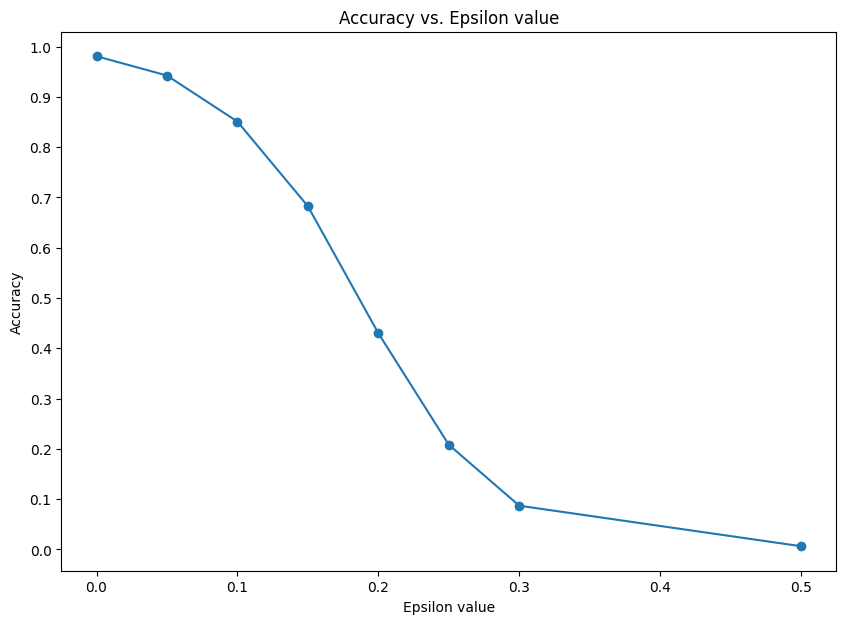

In [12]:
# Initialize figure
plt.figure(figsize = (10, 7))

# Display accuracy vs. Epsilon values plot
plt.plot(epsilons, accuracies, "o-")

# Adjust x-axis and y-axis labels and ticks
plt.yticks(np.arange(0, 1.1, step = 0.1))
#plt.xticks(np.arange(0, .35, step = 0.05))
plt.title("Accuracy vs. Epsilon value")
plt.xlabel("Epsilon value")
plt.ylabel("Accuracy")

# Display
plt.show()

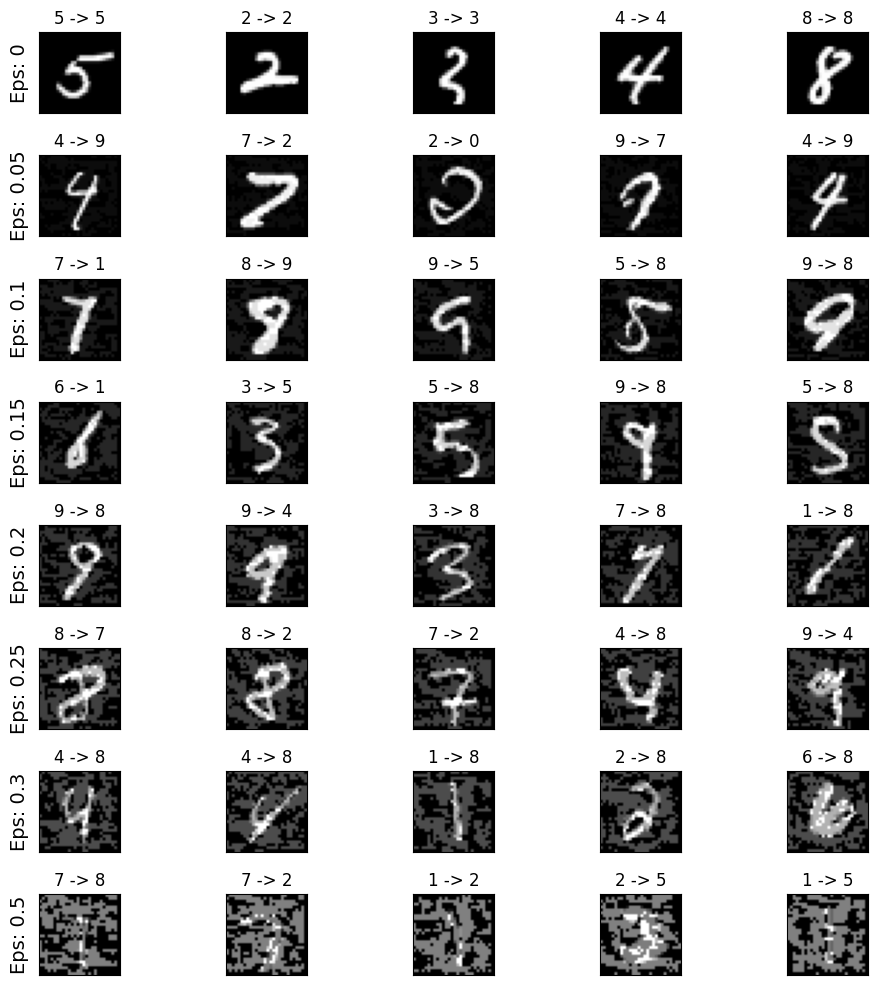

In [13]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0

# Initialize figure
plt.figure(figsize = (10, 10))

# Browse through epsilon values and adversarial examples
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        
        # Remove x-axis and y-axis ticks from plot
        plt.xticks([], [])
        plt.yticks([], [])
        
        # Labels for y axis
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize = 14)
            
        # Labels for each image subplot
        orig, adv, ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        
        # Display image
        plt.imshow(ex, cmap = "gray")
        
# Display full plot
plt.tight_layout()
plt.show()